In [1]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy import interp
import matplotlib.pyplot as plt
import dataset_utils
import os

In [2]:
def fit_roc(clf, genes, title='Receiver Operating Characteristic'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i in range(5):
        train, test = train_sets[i], test_sets[i]
        X, y = train[genes], train['responses'].astype(int)
        X_test, y_test = test[genes], test['responses'].astype(int)

        probas_ = clf.fit(X, y).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
    return tprs, aucs

def plot_ensemble(clf, top_gene_sets, title='Ensemble ROC'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i in range(5):
        train, test = train_sets[i], test_sets[i]
        
        probas_ = np.array([0 for _ in range(len(test))])
        for gene_set in top_gene_sets:
            genes = dataset_utils.get_genes(gene_set + ".txt")
            X, y = train[genes], train['responses'].astype(int)
            X_test, y_test = test[genes], test['responses'].astype(int)
            p = clf.fit(X, y).predict_proba(X_test)[:, 1] / float(len(top_gene_sets))
            probas_ = probas_ + p

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
    return dataset_utils.plot_roc(tprs, aucs, title)

In [3]:
train_sets, test_sets = dataset_utils.kfold_train_test_sets('../l_rnaseq_scaled_symbols.csv')
pathways = sorted(os.listdir('gene_sets'))

## Random Forest Metrics

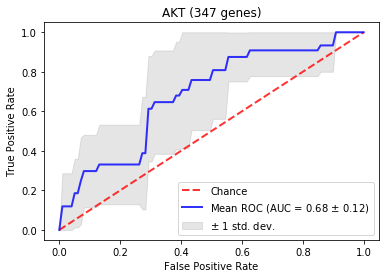

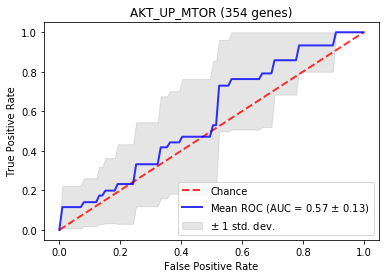

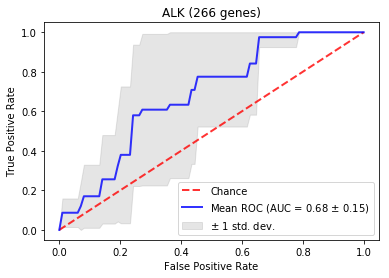

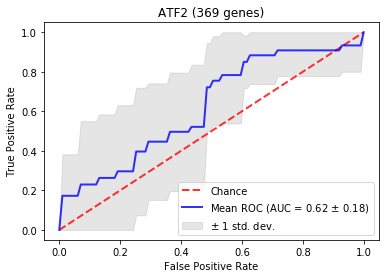

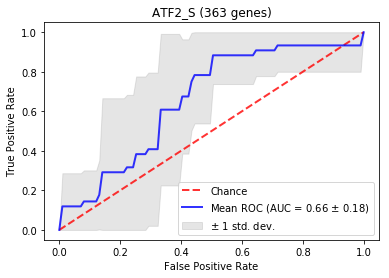

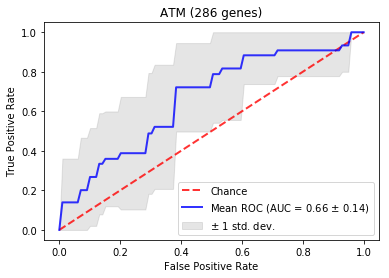

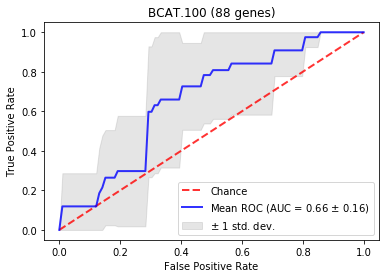

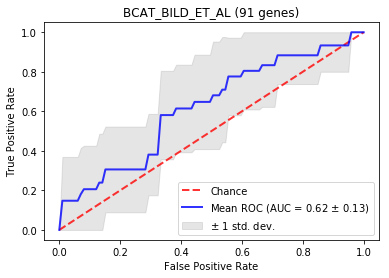

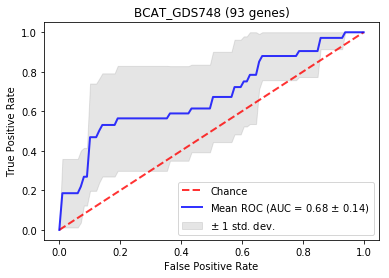

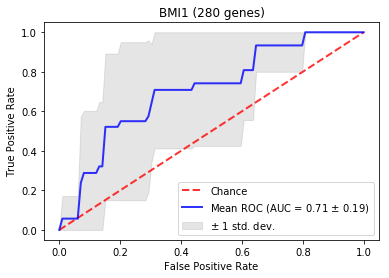

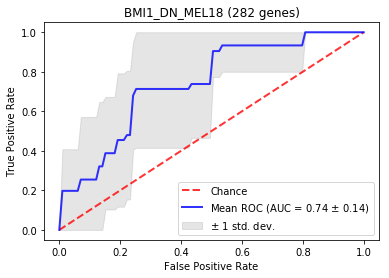

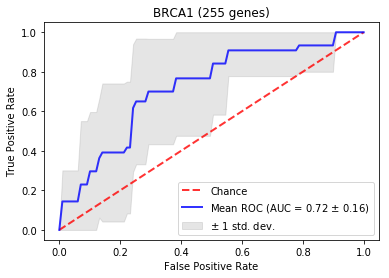

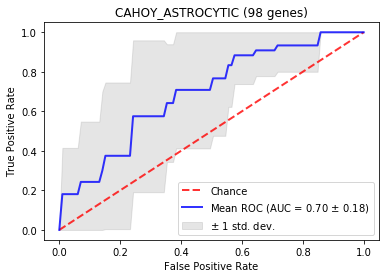

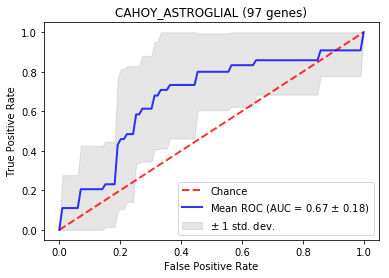

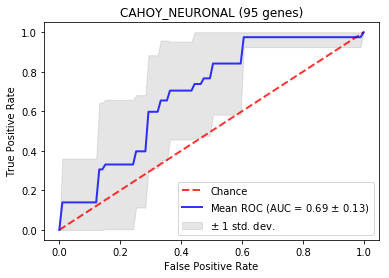

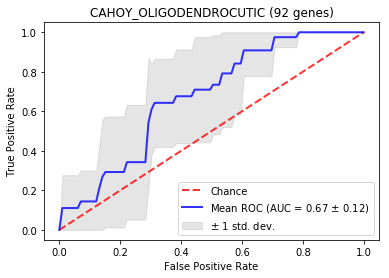

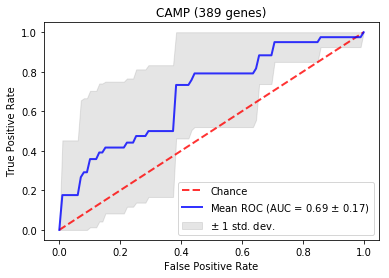

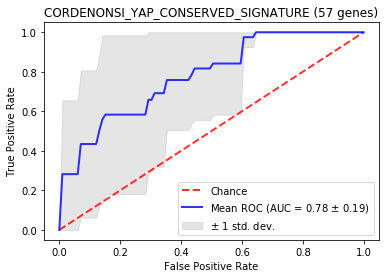

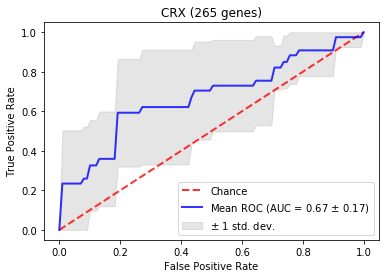

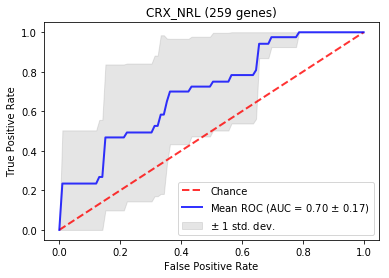

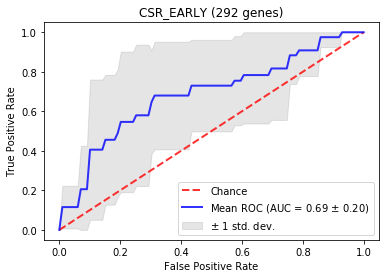

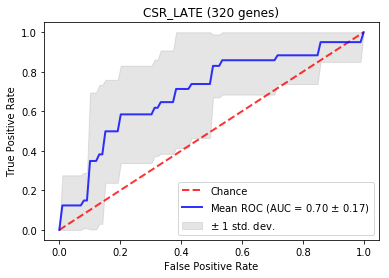

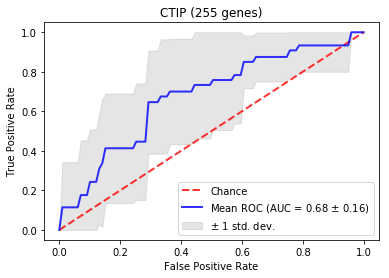

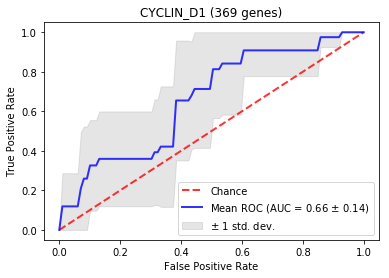

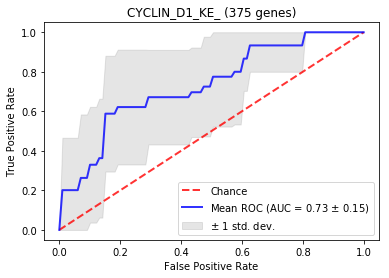

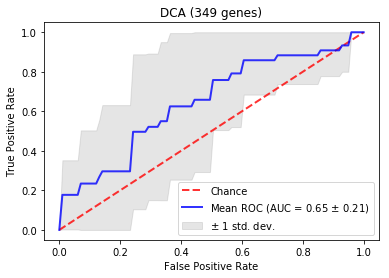

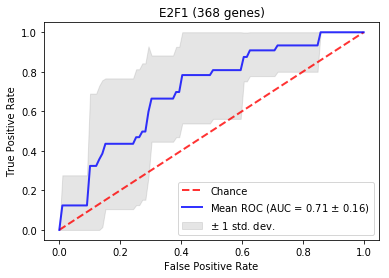

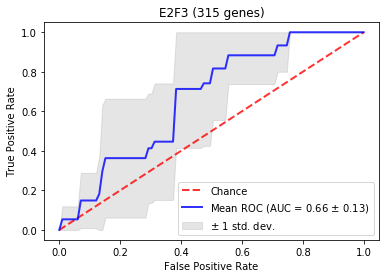

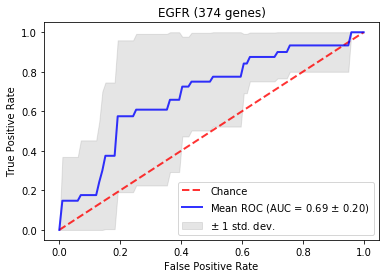

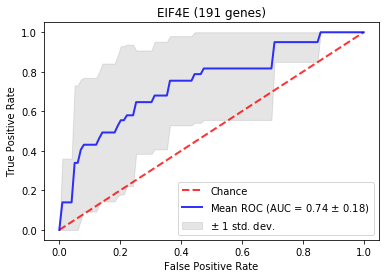

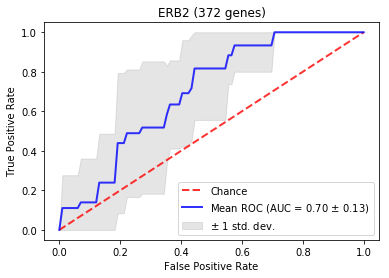

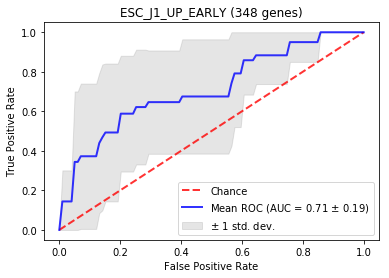

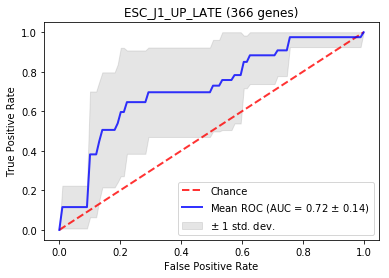

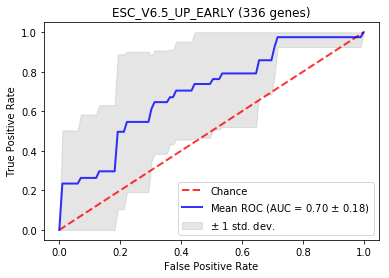

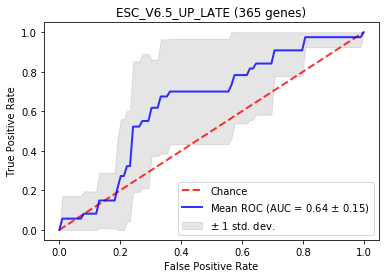

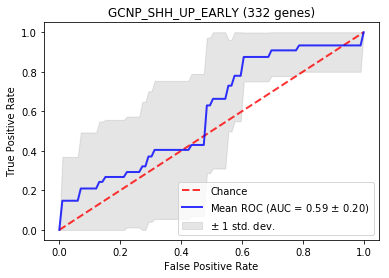

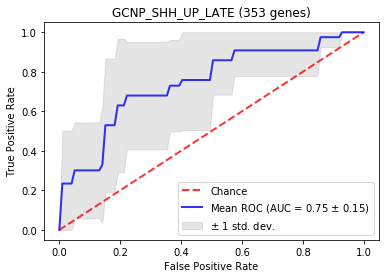

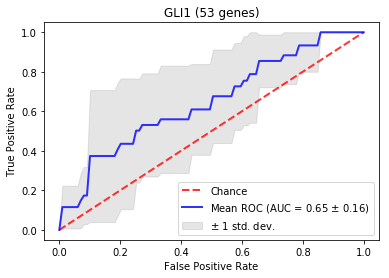

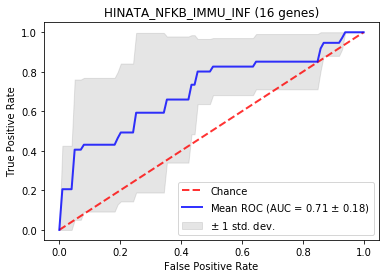

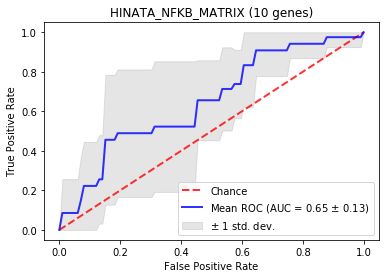

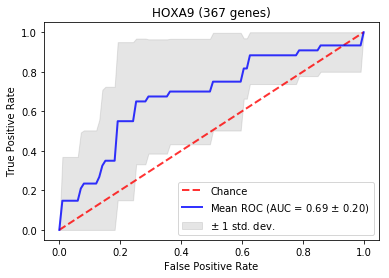

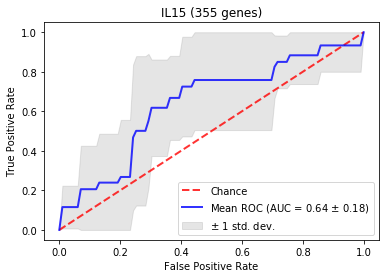

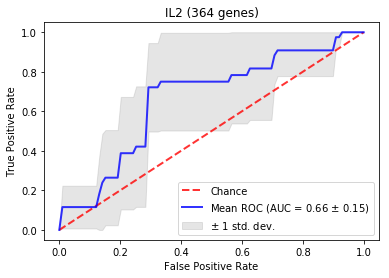

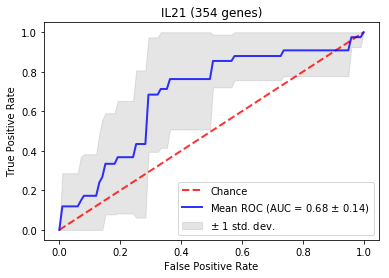

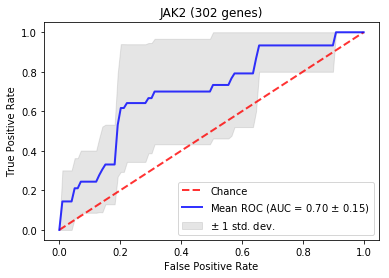

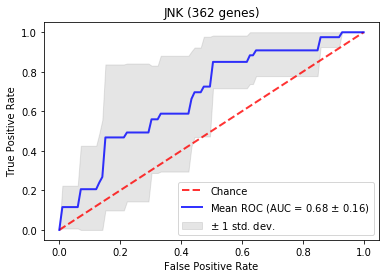

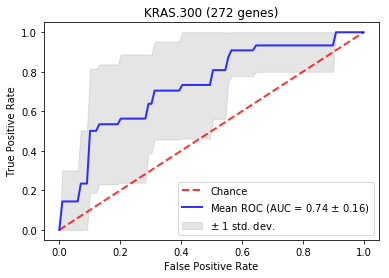

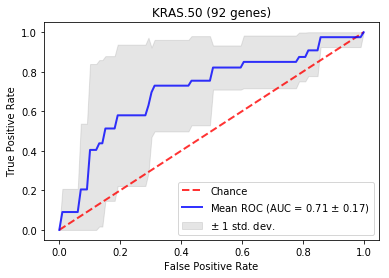

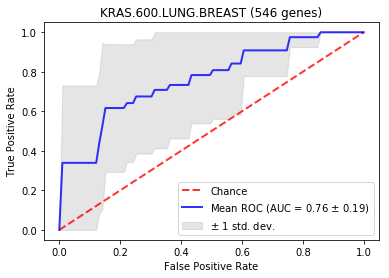

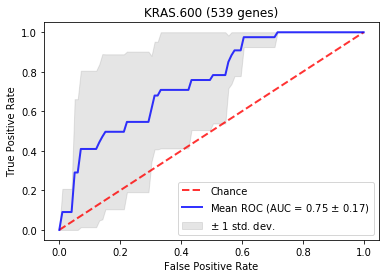

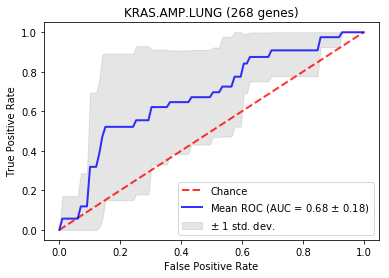

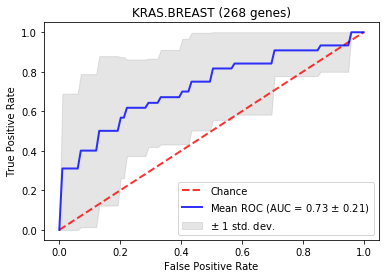

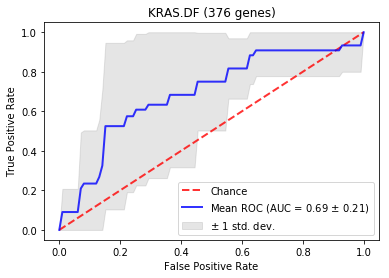

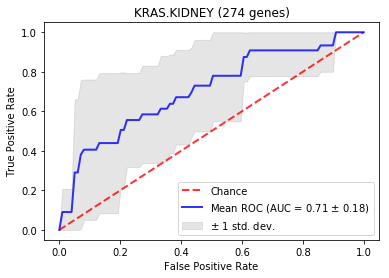

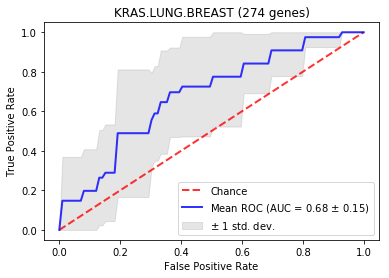

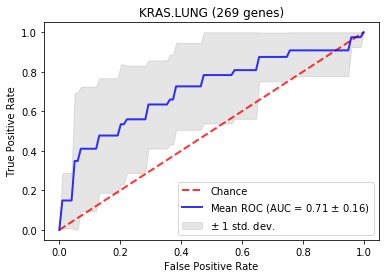

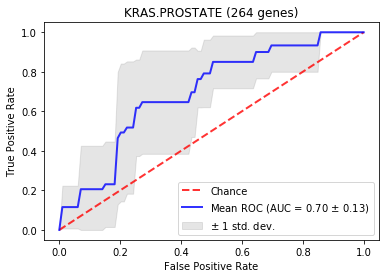

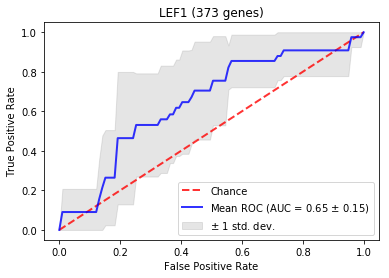

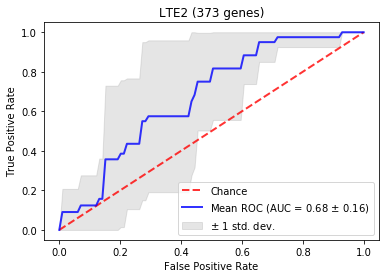

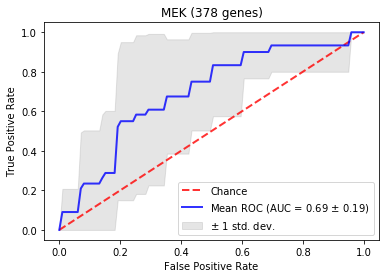

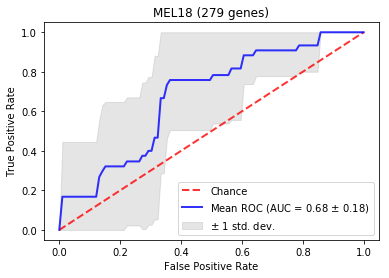

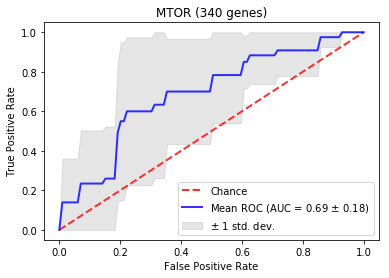

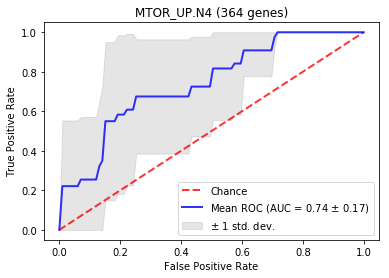

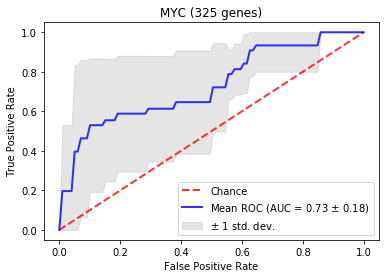

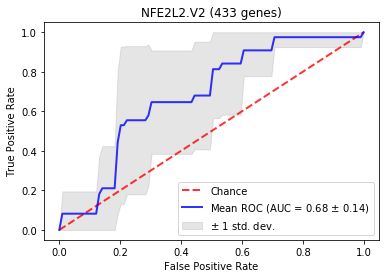

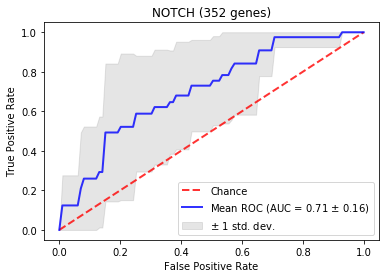

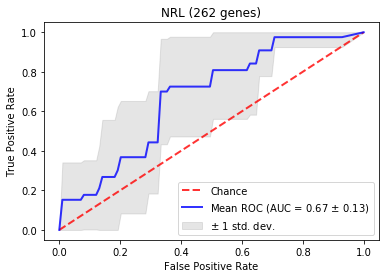

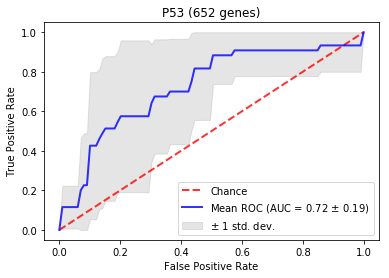

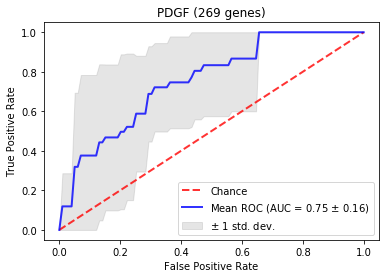

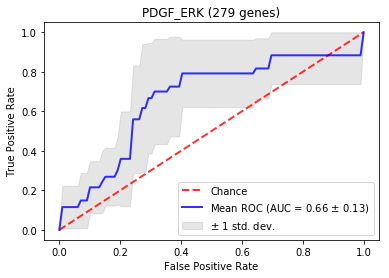

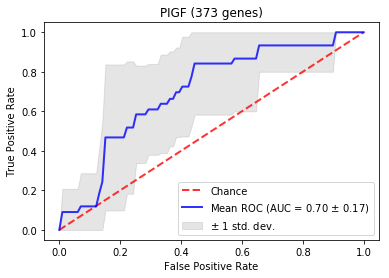

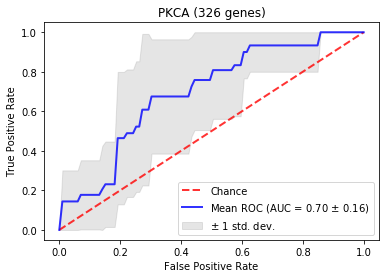

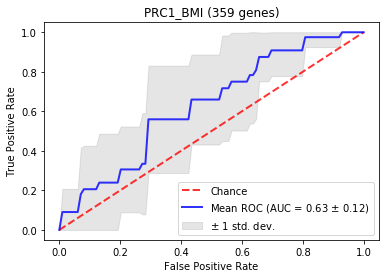

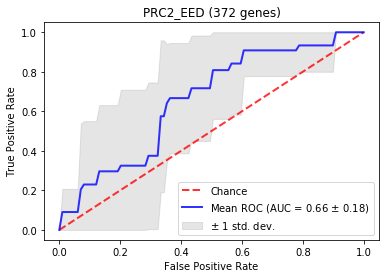

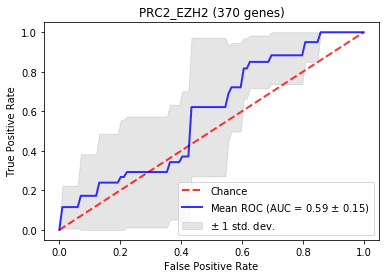

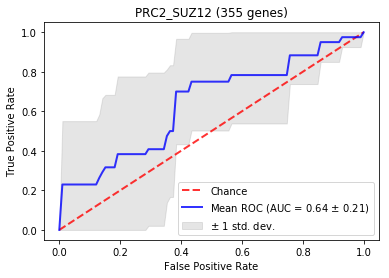

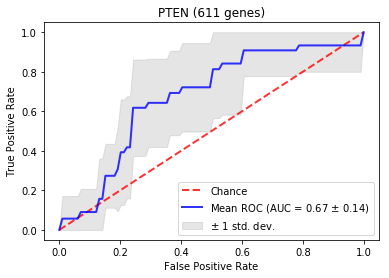

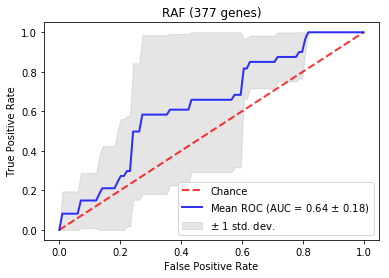

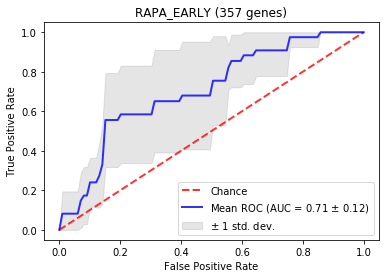

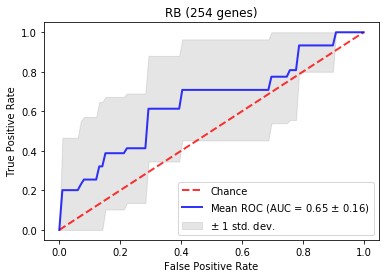

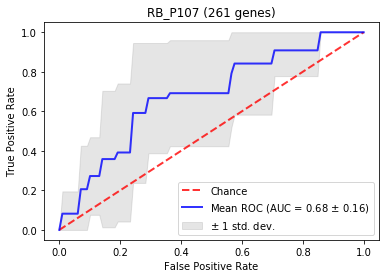

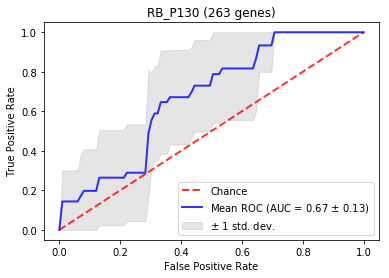

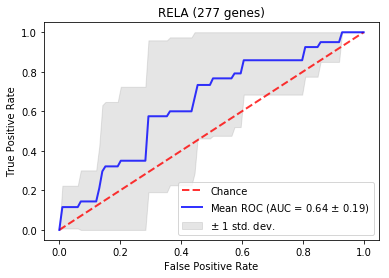

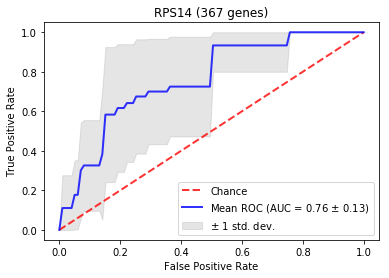

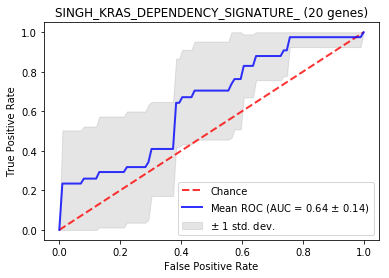

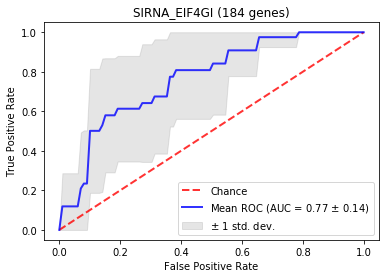

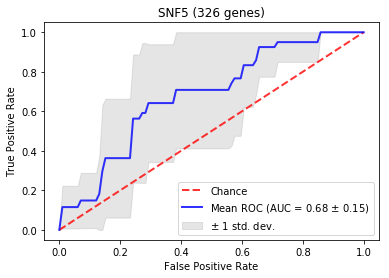

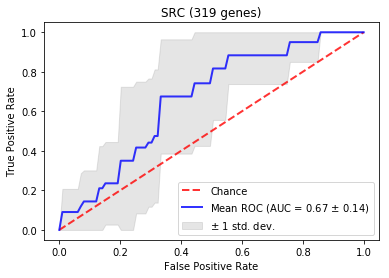

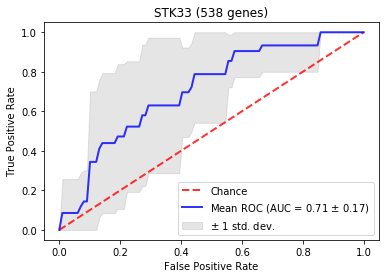

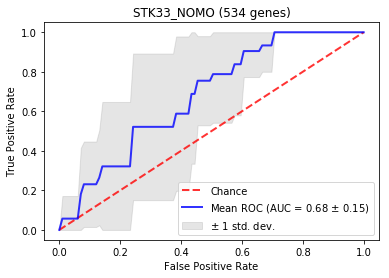

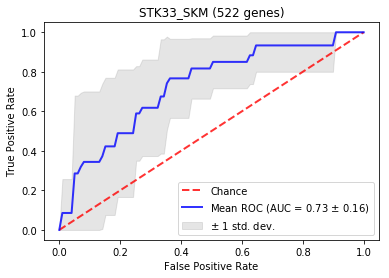

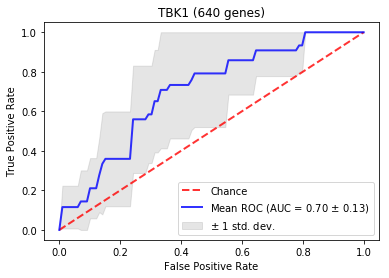

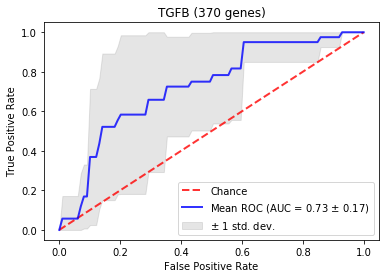

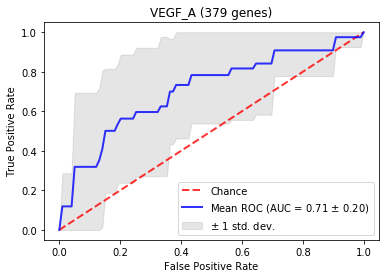

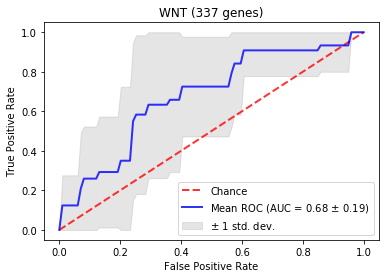

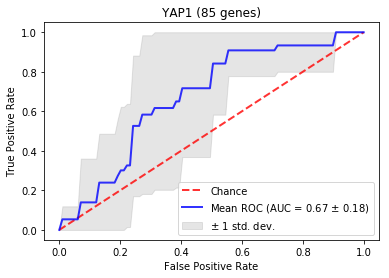

In [4]:
rf_perf = []
for p in pathways:
    clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=7)
    genes = dataset_utils.get_genes(p)
    name = "{} ({} genes)".format('.'.join(p.split('.')[:-1]), len(genes))
    tprs, aucs = fit_roc(clf, genes)
    mean_auc = dataset_utils.plot_roc(tprs, aucs, name)
    rf_perf.append((name, mean_auc))

In [5]:
# get top 10 gene sets (by AUROC)
rf_perf.sort(key=lambda x: x[1], reverse=True)
for i in range(10):
    print("{}\t{}".format(rf_perf[i][1], rf_perf[i][0]))

0.7795574795574796	CORDENONSI_YAP_CONSERVED_SIGNATURE (57 genes)
0.7657527657527657	SIRNA_EIF4GI (184 genes)
0.7634078884078883	KRAS.600.LUNG.BREAST (546 genes)
0.7588985088985087	RPS14 (367 genes)
0.7545454545454545	PDGF (269 genes)
0.7487373737373737	KRAS.600 (539 genes)
0.7451779701779702	GCNP_SHH_UP_LATE (353 genes)
0.7407046657046656	BMI1_DN_MEL18 (282 genes)
0.7406926406926406	MTOR_UP.N4 (364 genes)
0.7405363155363154	EIF4E (191 genes)


# Metrics for SVM 

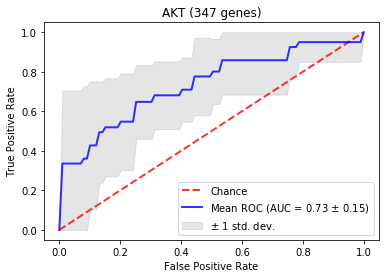

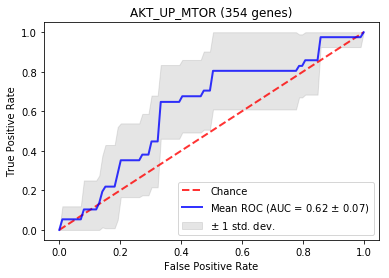

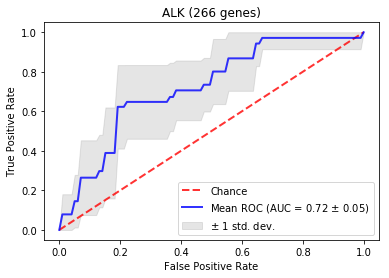

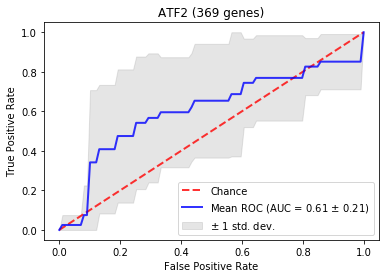

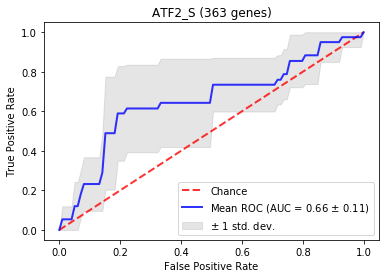

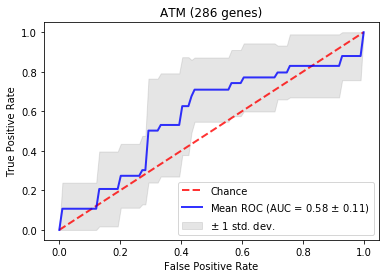

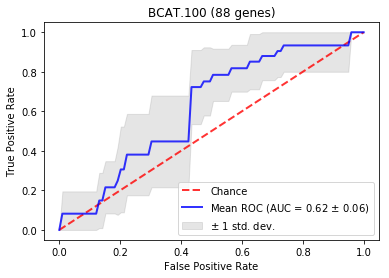

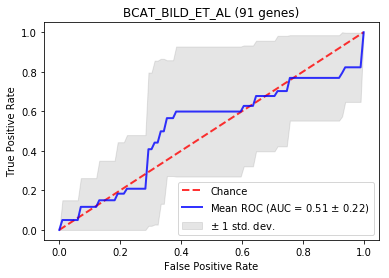

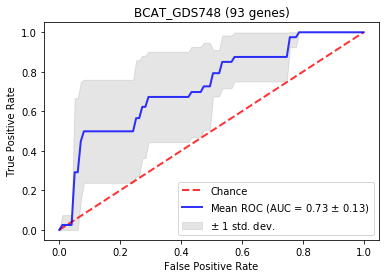

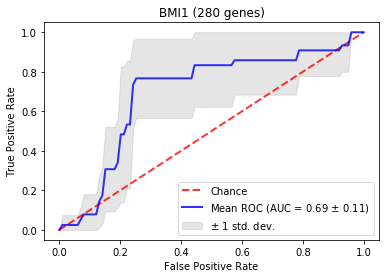

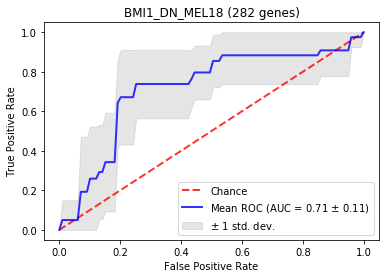

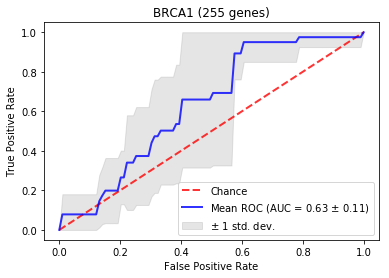

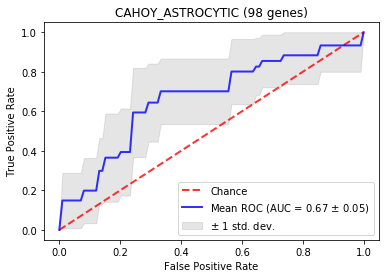

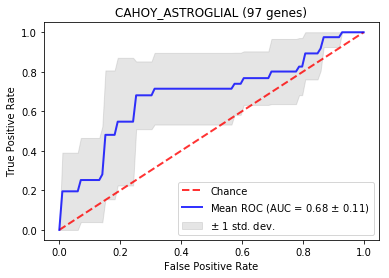

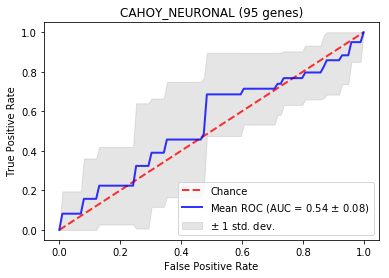

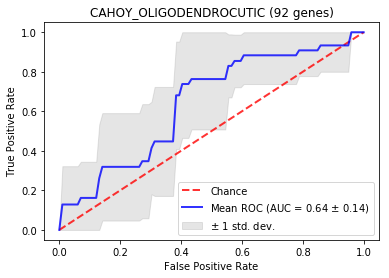

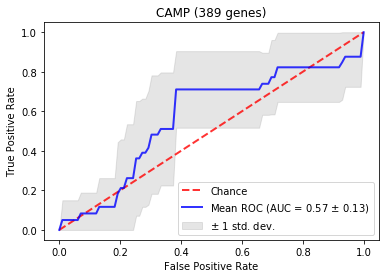

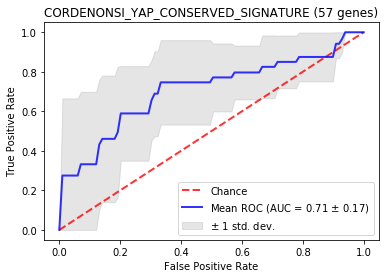

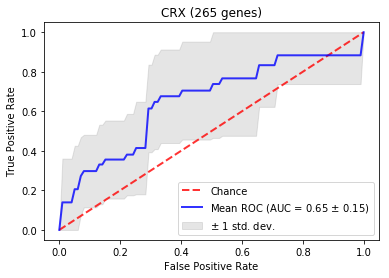

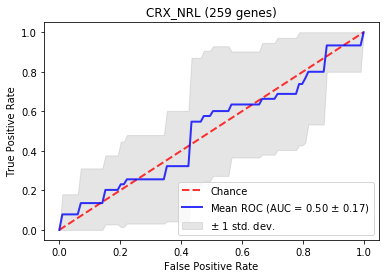

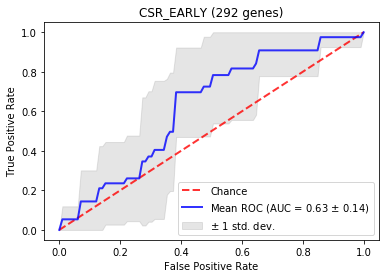

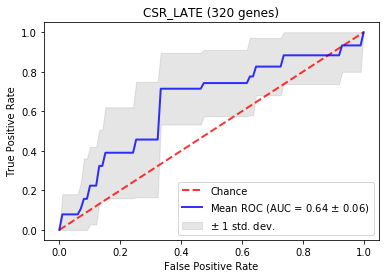

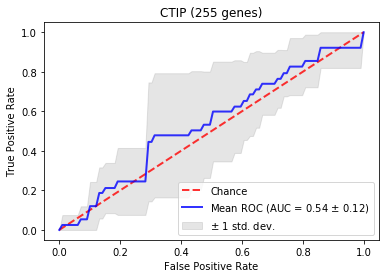

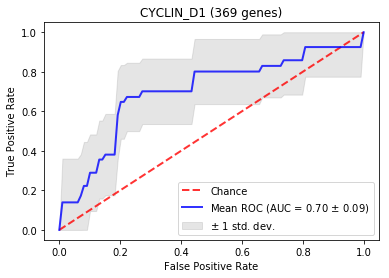

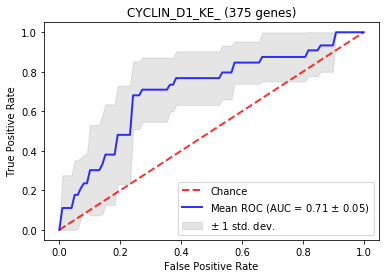

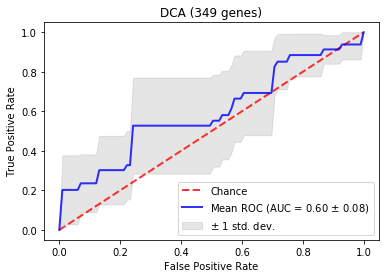

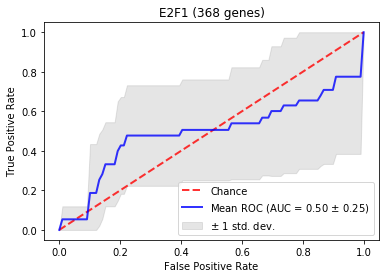

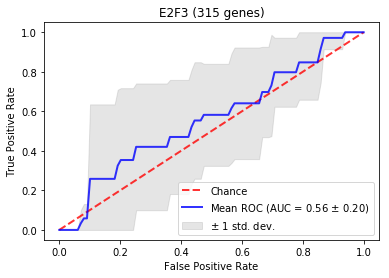

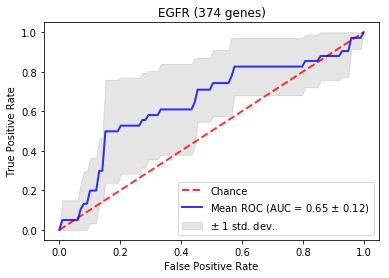

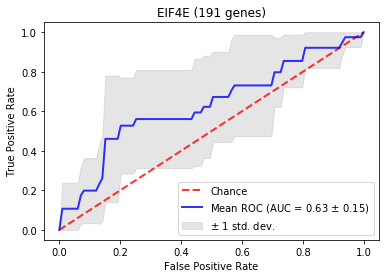

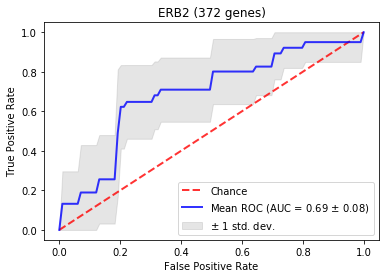

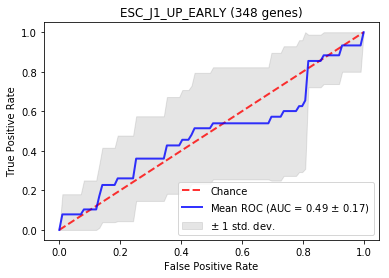

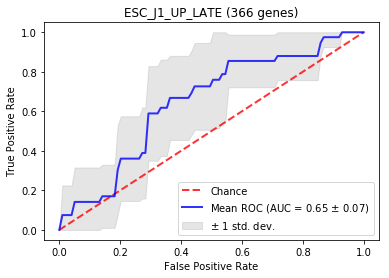

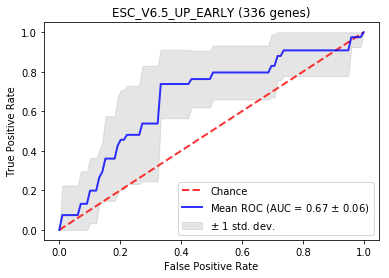

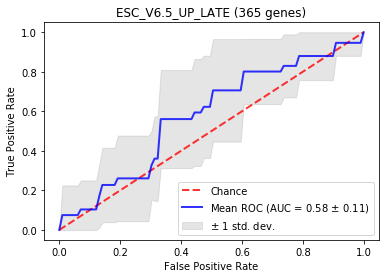

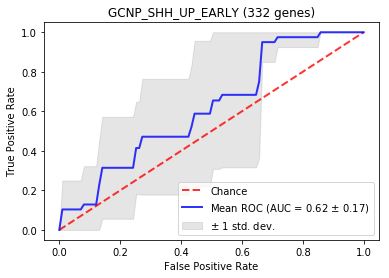

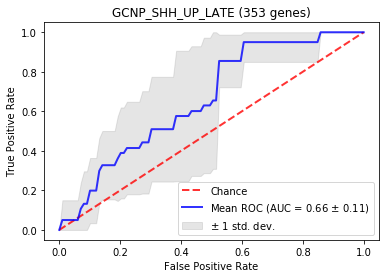

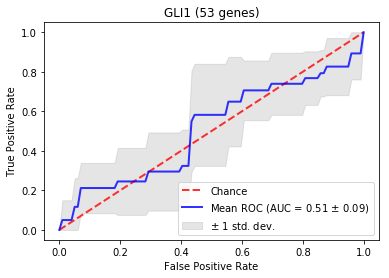

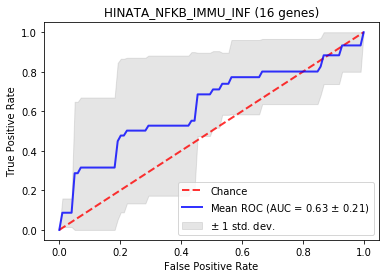

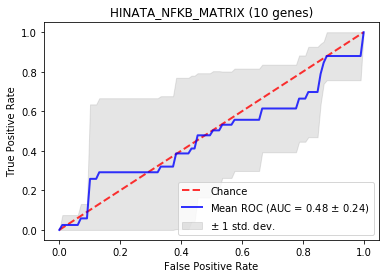

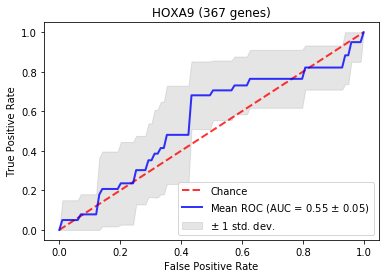

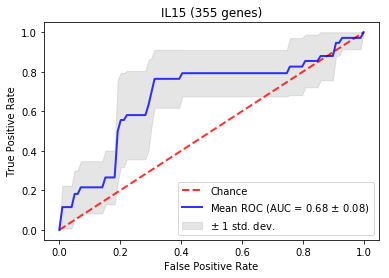

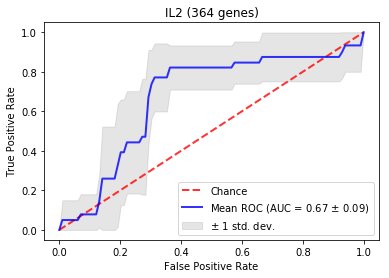

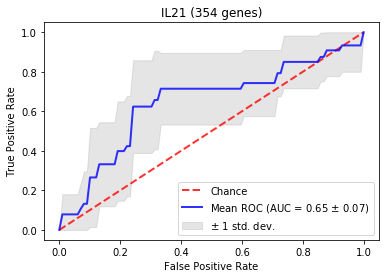

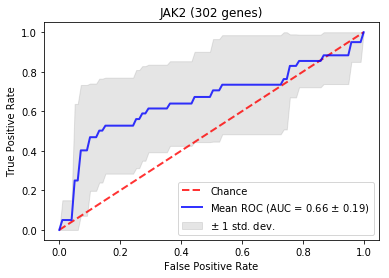

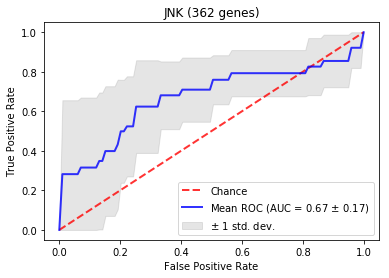

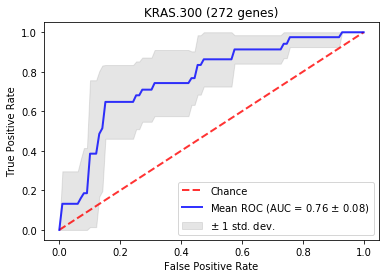

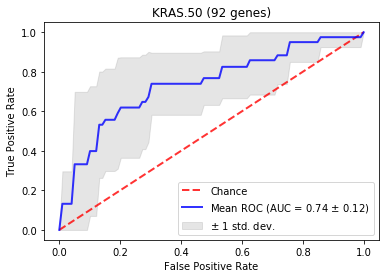

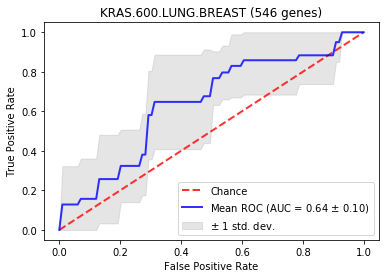

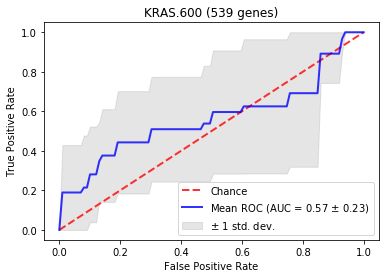

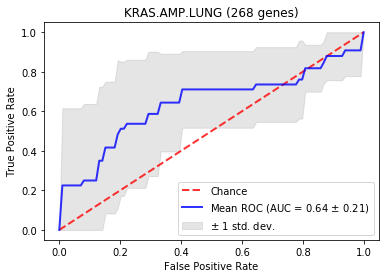

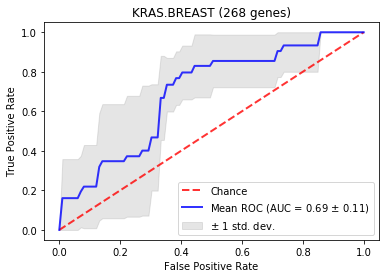

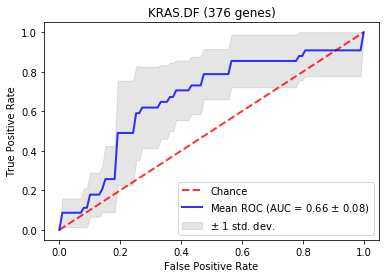

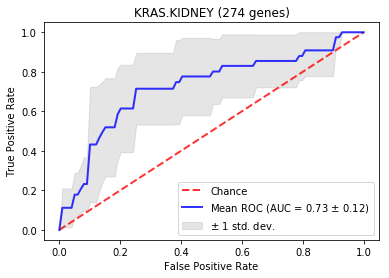

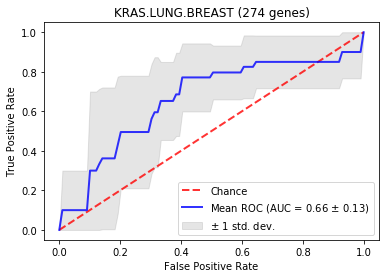

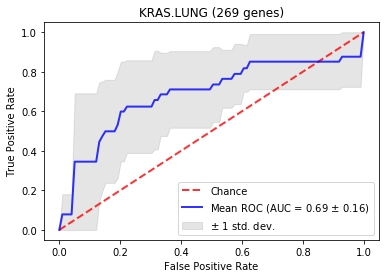

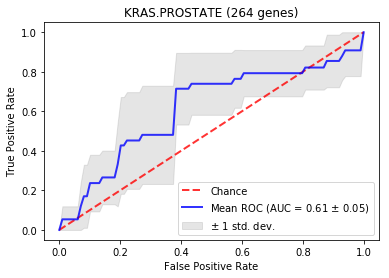

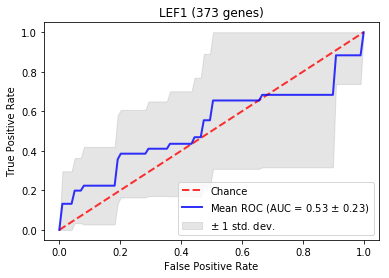

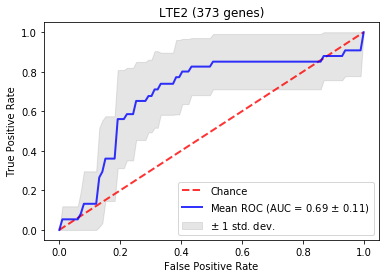

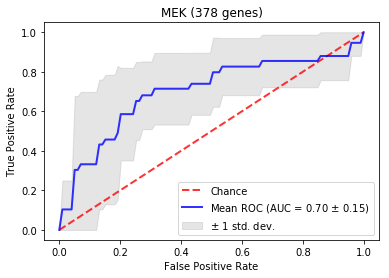

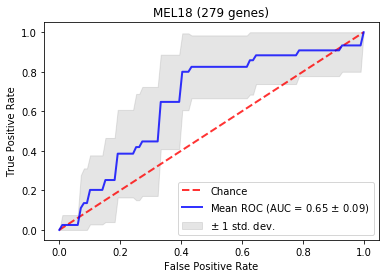

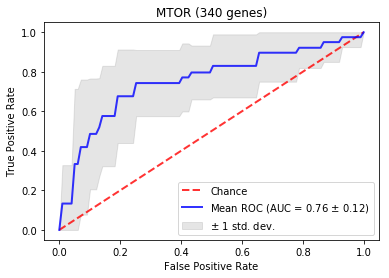

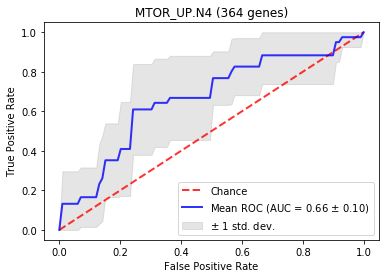

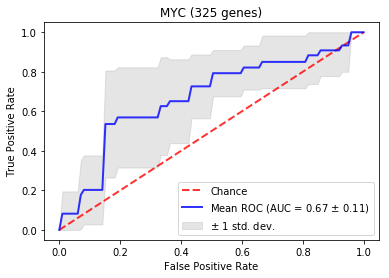

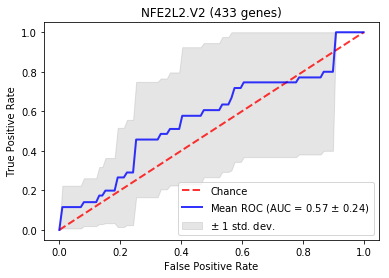

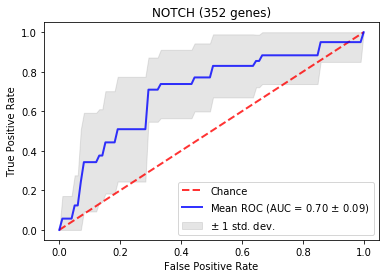

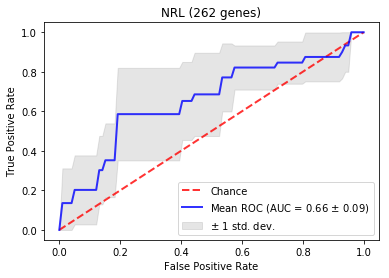

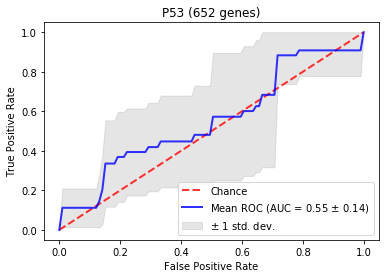

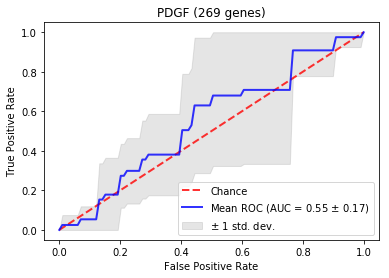

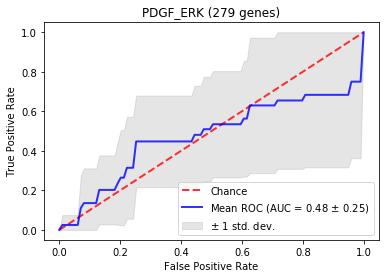

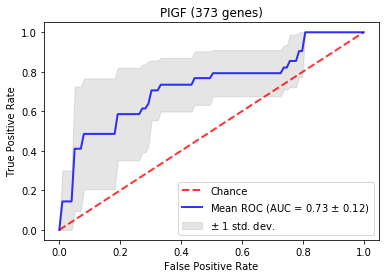

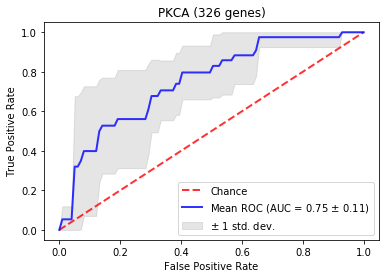

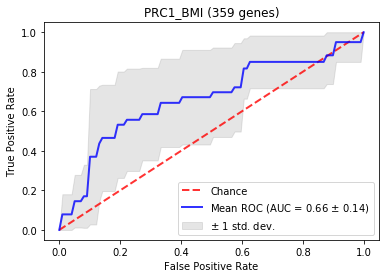

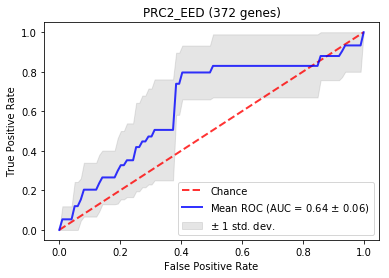

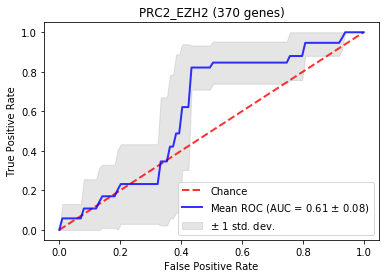

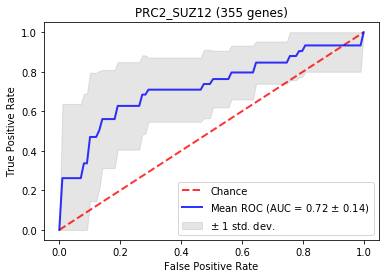

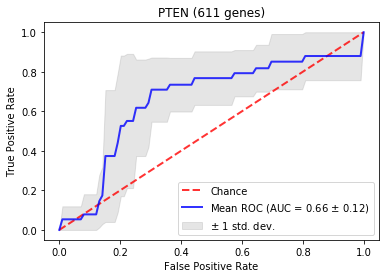

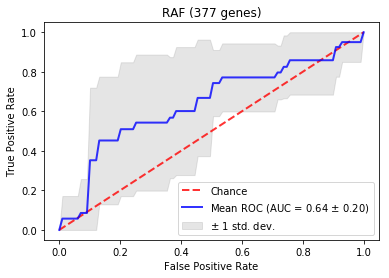

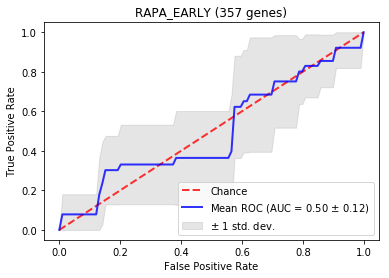

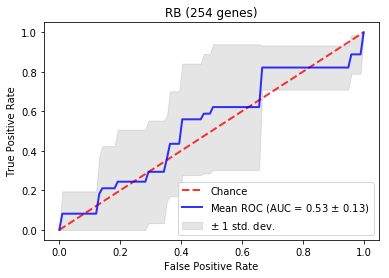

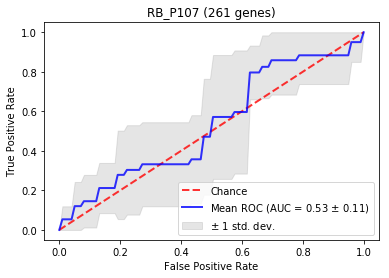

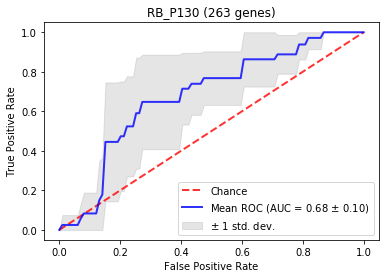

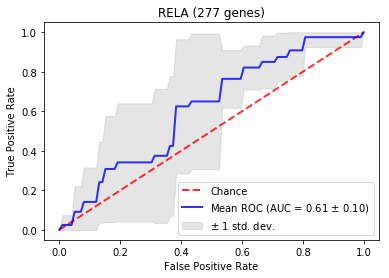

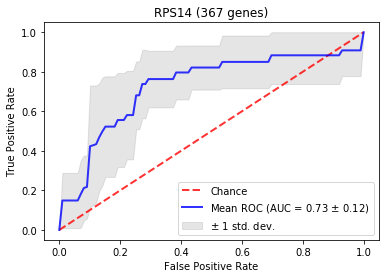

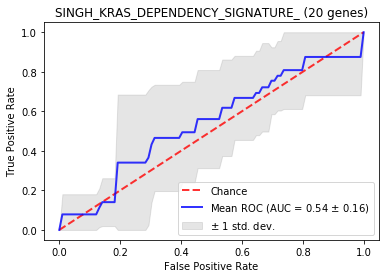

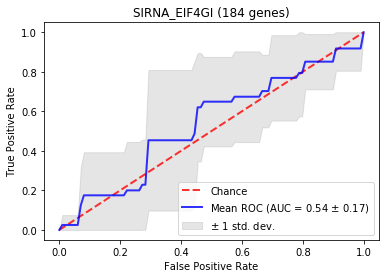

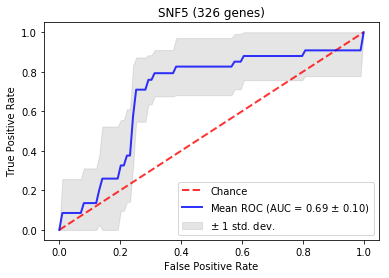

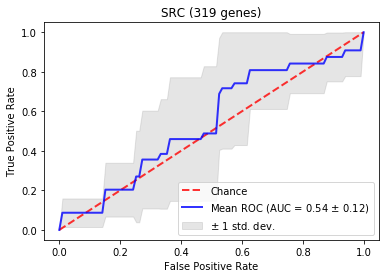

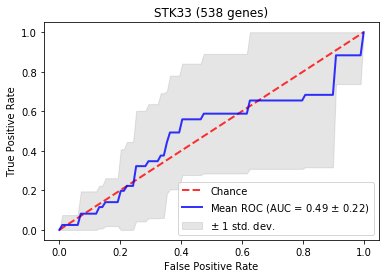

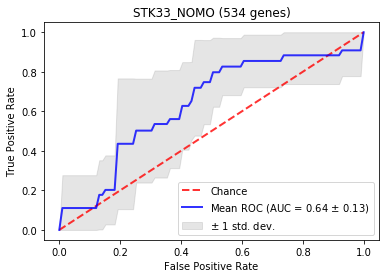

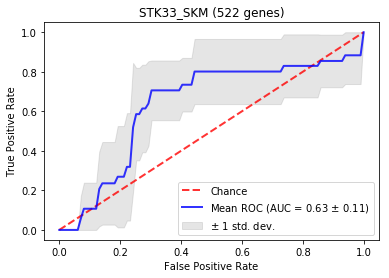

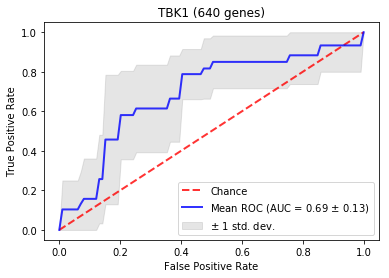

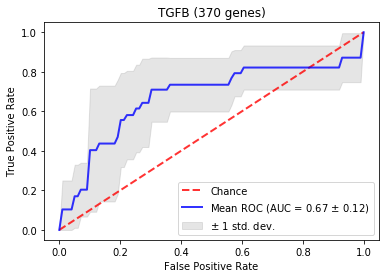

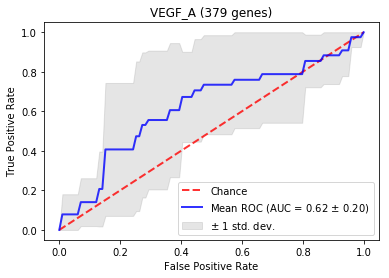

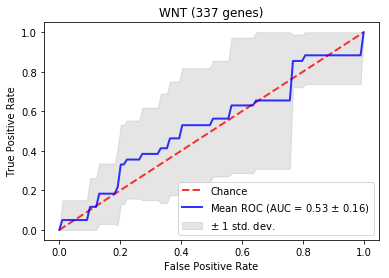

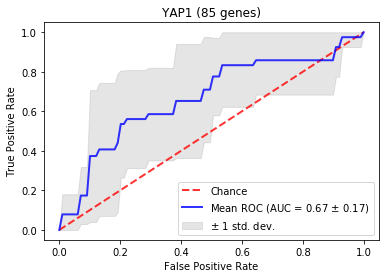

In [6]:
svm_perf = []
for p in pathways:
    clf = SVC(gamma='auto', probability=True)
    genes = dataset_utils.get_genes(p)
    name = "{} ({} genes)".format('.'.join(p.split('.')[:-1]), len(genes))
    tprs, aucs = fit_roc(clf, genes)
    mean_auc = dataset_utils.plot_roc(tprs, aucs, name)
    svm_perf.append((name, mean_auc))

In [7]:
# get top 10 gene sets (by AUROC)
svm_perf.sort(key=lambda x: x[1], reverse=True)
for i in range(10):
    print("{}\t{}".format(svm_perf[i][1], svm_perf[i][0]))

0.7623857623857624	KRAS.300 (272 genes)
0.7565656565656564	MTOR (340 genes)
0.7514670514670514	PKCA (326 genes)
0.738167388167388	KRAS.50 (92 genes)
0.734307359307359	AKT (347 genes)
0.7305796055796056	BCAT_GDS748 (93 genes)
0.7299182299182299	PIGF (373 genes)
0.726610622822744	RPS14 (367 genes)
0.7252405002405002	KRAS.KIDNEY (274 genes)
0.7226430976430975	PRC2_SUZ12 (355 genes)


In [8]:
# get union of top K gene_sets
K = 2
top_union = dataset_utils.get_gene_sets_union(svm_perf, K)
print("Lapatinib treatment: {} total genes in top {} gene sets".format(len(top_union), K))

Lapatinib treatment: 607 total genes in top 2 gene sets


In [9]:
# SVM on only genes from top gene sets
top_genes = list(top_union)
clf = SVC(gamma='auto', probability=True)
plot_roc(clf, top_genes, "Top {} Gene Sets (Lapatinib)".format(K))

NameError: name 'plot_roc' is not defined

In [ ]:
# Ensemble with top gene sets
K = 2
top_gene_sets = [svm_perf[i][0].split()[0] for i in range(K)]
plot_ensemble(SVC(gamma='auto', probability=True), top_gene_sets)